In [ ]:
# --- 1. SETUP: Install libraries, mount drive, and extract data ---
print("STEP 1: Installing utilities ('timm' and 'unrar')...")
!pip install -q timm
!sudo apt-get -y install unrar > /dev/null
print("✅ Utilities installed.")

import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
import timm
import matplotlib.pyplot as plt
import numpy as np

STEP 1: Installing utilities ('timm' and 'unrar')...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.9 MB/s eta 0:00:00
✅ Utilities installed.


In [ ]:
# Mount Google Drive
print("\nSTEP 2: Mounting Google Drive...")
drive.mount('/content/drive')

# Define Paths and Extract Data
GDRIVE_ARCHIVE_PATH = "/content/drive/My Drive/UBC_Fashion_Project/quality_sorted_dataset.rar"
LOCAL_BASE_PATH = "/content/local_quality_dataset"
LOCAL_ARCHIVE_PATH = "/content/quality_sorted_dataset.rar"

print("\nSTEP 3: Preparing local dataset...")
shutil.rmtree(LOCAL_BASE_PATH, ignore_errors=True)
if os.path.exists(LOCAL_ARCHIVE_PATH):
    os.remove(LOCAL_ARCHIVE_PATH)

if not os.path.exists(GDRIVE_ARCHIVE_PATH):
    print(f"❌ CRITICAL ERROR: Archive not found at '{GDRIVE_ARCHIVE_PATH}'")
else:
    shutil.copy(GDRIVE_ARCHIVE_PATH, LOCAL_ARCHIVE_PATH)
    !unrar x -o+ "{LOCAL_ARCHIVE_PATH}" "{LOCAL_BASE_PATH}/" > /dev/null
    print("✅ Dataset extracted and ready.")


STEP 2: Mounting Google Drive...
Mounted at /content/drive

STEP 3: Preparing local dataset...
✅ Dataset extracted and ready.


In [ ]:
# --- 2. CONFIGURATION AND DATALOADERS ---
print("\nSTEP 4: Configuring model and dataloaders for Phase 1...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_path = "/content/local_quality_dataset/quality_sorted_dataset/train"
val_path = "/content/local_quality_dataset/quality_sorted_dataset/validation"
phase1_model_path = "/content/drive/My Drive/ProMotionFx_CNN_Skeleton/vit_skeleton.pth"

# Hyperparameters
img_size = (224, 224);
batch_size = 32;
num_epochs = 10;
learning_rate = 1e-3;
patience = 3

# Transforms and Dataloaders
train_transforms = transforms.Compose([transforms.Resize(img_size),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize(img_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_path, transform=val_transforms)
class_names = train_dataset.classes

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


STEP 4: Configuring model and dataloaders for Phase 1...


In [ ]:
# --- 3. MODEL DEFINITION AND TRAINING ---
print("\nSTEP 5: Defining and Training the ViT Model (Head Only)...")
model = timm.create_model('vit_base_patch16_224', pretrained=True)
for param in model.parameters(): param.requires_grad = False

num_ftrs = model.head.in_features
model.head = nn.Sequential(nn.Linear(num_ftrs, 128),
                           nn.ReLU(),
                           nn.Dropout(0.3),
                           nn.Linear(128, 1),
                           nn.Sigmoid())

for param in model.head.parameters(): param.requires_grad = True
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.head.parameters(), lr=learning_rate)

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_acc = 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        preds = (outputs >= 0.5).float()
        running_corrects += torch.sum(preds == labels.data)
        total += labels.size(0)
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = running_corrects.double() / len(train_dataset)

    model.eval()
    running_loss, running_corrects, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = (outputs >= 0.5).float()
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
    epoch_val_loss = running_loss / len(val_dataset)
    epoch_val_acc = running_corrects.double() / len(val_dataset)

    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc.item())

    print(f"\nEpoch {epoch+1}/{num_epochs}\nTrain Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}\nVal   Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        epochs_no_improve = 0
        torch.save({'model_state': model.state_dict(), 'best_val_acc': best_val_acc, 'history': history}, phase1_model_path)
        print(f"Validation accuracy improved. Best model saved to {phase1_model_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered.")
            break

print(f"\n✅ Phase 1 Training Complete. Best validation accuracy: {best_val_acc:.4f}")


STEP 5: Defining and Training the ViT Model (Head Only)...


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Epoch 1/10
Train Loss: 0.3686 Acc: 0.8355
Val   Loss: 0.3139 Acc: 0.8735
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Skeleton/vit_skeleton.pth

Epoch 2/10
Train Loss: 0.3261 Acc: 0.8600
Val   Loss: 0.3015 Acc: 0.8762
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Skeleton/vit_skeleton.pth

Epoch 3/10
Train Loss: 0.3131 Acc: 0.8647
Val   Loss: 0.3025 Acc: 0.8746

Epoch 4/10
Train Loss: 0.2978 Acc: 0.8733
Val   Loss: 0.2936 Acc: 0.8779
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Skeleton/vit_skeleton.pth

Epoch 5/10
Train Loss: 0.2977 Acc: 0.8733
Val   Loss: 0.2932 Acc: 0.8810
Validation accuracy improved. Best model saved to /content/drive/My Drive/ProMotionFx_CNN_Skeleton/vit_skeleton.pth

Epoch 6/10
Train Loss: 0.2925 Acc: 0.8781
Val   Loss: 0.3112 Acc: 0.8789

Epoch 7/10
Train Loss: 0.2906 Acc: 0.8807
Val   Loss: 0.2808 Acc: 0.8887
Validation accurac


STEP 6: Plotting training and validation curves...


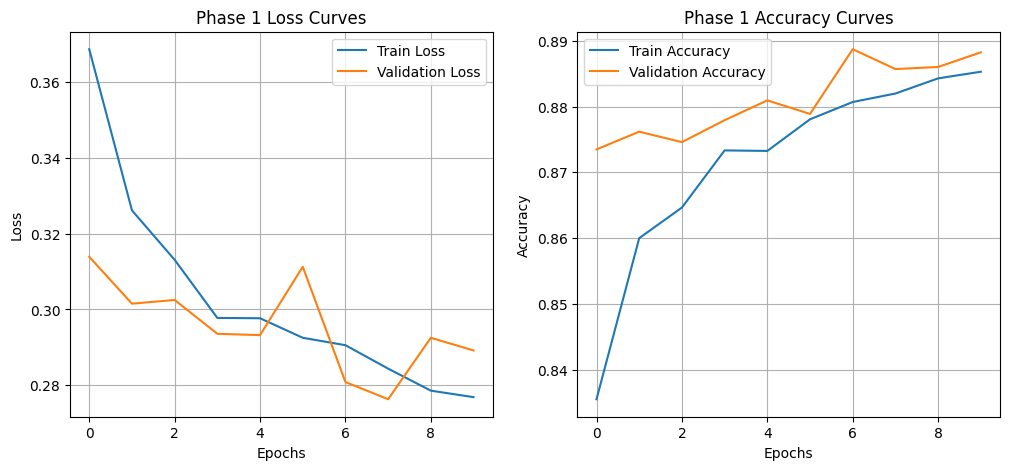

In [ ]:
# --- 4. PLOT TRAINING CURVES ---
print("\nSTEP 6: Plotting training and validation curves...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Phase 1 Loss Curves'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Phase 1 Accuracy Curves'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
plt.show()

STEP 1: Installing utilities and importing libraries...

STEP 2: Configuring for evaluation...
Mounted at /content/drive
Local test set found.

STEP 3: Loading the Phase 1 model and test data...
✅ Model and test data loaded successfully.

STEP 4: Running evaluation...

--- Evaluation Results (After Phase 1 - Head Training) ---

Classification Report:
                precision    recall  f1-score   support

 bad_skeletons     0.9063    0.8890    0.8976      3026
good_skeletons     0.8911    0.9081    0.8995      3026

      accuracy                         0.8985      6052
     macro avg     0.8987    0.8985    0.8985      6052
  weighted avg     0.8987    0.8985    0.8985      6052


Overall Accuracy: 89.85%
Precision: 0.8911, Recall: 0.9081, AUC: 0.9566



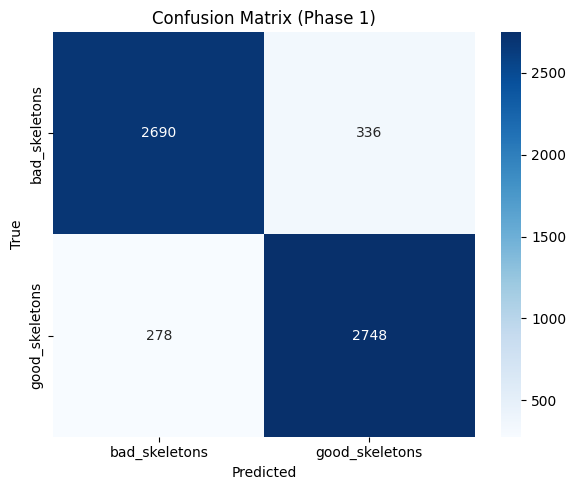

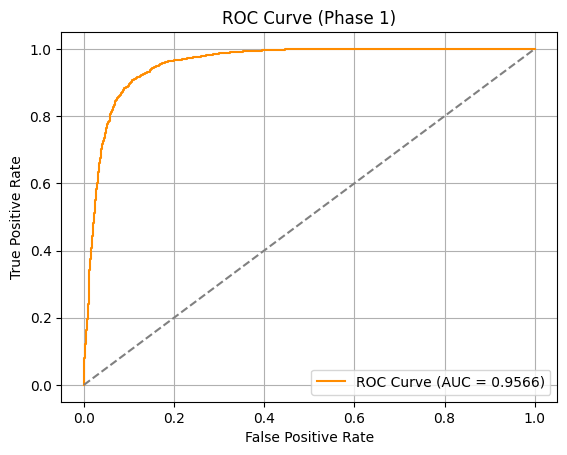

In [ ]:
# =================================================================
# EVALUATION SCRIPT FOR THE PHASE 1 (NORMAL) TRAINED MODEL
# =================================================================

# --- 1. SETUP LIBRARIES ---
print("STEP 1: Installing utilities and importing libraries...")
!pip install -q timm
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# --- 2. CONFIGURATION ---
print("\nSTEP 2: Configuring for evaluation...")
drive.mount('/content/drive', force_remount=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- IMPORTANT: Path to the model saved from PHASE 1 ---
best_model_path = "/content/drive/My Drive/ProMotionFx_CNN_Skeleton/vit_skeleton.pth"

# Path to your test data
test_path = "/content/local_quality_dataset/quality_sorted_dataset/test"

# Make sure the local data exists if this is a new session
if not os.path.exists(test_path):
    print("Local dataset not found. Please run the data setup part of the training script first.")
else:
    print("Local test set found.")

# --- 3. LOAD CHECKPOINT AND PREPARE MODEL ---
print("\nSTEP 3: Loading the Phase 1 model and test data...")
if not os.path.exists(best_model_path):
    print(f"❌ CRITICAL ERROR: Model checkpoint not found at '{best_model_path}'")
else:
    checkpoint = torch.load(best_model_path)

    img_size = (224, 224)
    batch_size = 32

    # Dataloader for test set
    test_transforms = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    class_names = test_dataset.classes

    # Define the ViT model architecture
    eval_model = timm.create_model('vit_base_patch16_224', pretrained=False)
    num_ftrs = eval_model.head.in_features
    eval_model.head = nn.Sequential(
        nn.Linear(num_ftrs, 128), nn.ReLU(), nn.Dropout(0.3), nn.Linear(128, 1), nn.Sigmoid()
    )

    # Load the weights from the Phase 1 checkpoint
    eval_model.load_state_dict(checkpoint['model_state'])
    eval_model.to(device)
    eval_model.eval()
    print("✅ Model and test data loaded successfully.")

    # --- 4. RUN EVALUATION ---
    print("\nSTEP 4: Running evaluation...")
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = eval_model(images).squeeze()
            probs = outputs.cpu().numpy()
            preds = (outputs >= 0.5).float().cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
            all_probs.extend(probs)

    # --- 5. DISPLAY METRICS AND PLOTS ---
    print("\n--- Evaluation Results (After Phase 1 - Head Training) ---")
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    auc_score = roc_auc_score(all_labels, all_probs)
    precision = cm[1,1] / (cm[0,1] + cm[1,1]) if (cm[0,1] + cm[1,1]) > 0 else 0
    recall = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0

    print(f"\nOverall Accuracy: {acc*100:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc_score:.4f}\n")

    plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (Phase 1)'); plt.tight_layout(); plt.show()

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(); plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})', color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve (Phase 1)'); plt.legend(); plt.grid(True); plt.show()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
import timm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# --- 1. CONFIGURATION ---
print("STEP 1: Configuring model for Phase 2 Fine-tuning...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
phase1_model_path = "/content/drive/My Drive/ProMotionFx_CNN_Skeleton/vit_skeleton.pth"
finetuned_model_path = "/content/drive/My Drive/ProMotionFx_CNN_Skeleton/vit_finetuned_skeleton.pth"

# Hyperparameters
num_epochs = 15;
batch_size = 32;
img_size = (224, 224);
patience = 4
lr_head = 1e-5
lr_blocks = 1e-6

# --- 2. LOAD DATA AND MODEL ---
train_path = "/content/local_quality_dataset/quality_sorted_dataset/train"
val_path = "/content/local_quality_dataset/quality_sorted_dataset/validation"

# Data Transforms and Loaders
train_transforms = transforms.Compose([transforms.Resize(img_size),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize(img_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(train_path, transform=train_transforms);
val_dataset = datasets.ImageFolder(val_path, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2);
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Load model architecture and weights
model = timm.create_model('vit_base_patch16_224', pretrained=False)

num_ftrs = model.head.in_features
model.head = nn.Sequential(nn.Linear(num_ftrs, 128),
                           nn.ReLU(),
                           nn.Dropout(0.3),
                           nn.Linear(128, 1),
                           nn.Sigmoid())

checkpoint = torch.load(phase1_model_path)
model.load_state_dict(checkpoint['model_state'])
model.to(device)

best_val_acc = checkpoint['best_val_acc']
print(f"✅ Loaded model from Phase 1 with Val Acc: {best_val_acc:.4f}")

# --- 3. CONFIGURE MODEL FOR FINE-TUNING ---
for param in model.blocks[-2:].parameters(): param.requires_grad = True
optimizer = optim.Adam([{'params': model.head.parameters(), 'lr': lr_head},
                        {'params': model.blocks[-2:].parameters(), 'lr': lr_blocks}])
criterion = nn.BCELoss()

STEP 1: Configuring model for Phase 2 Fine-tuning...
✅ Loaded model from Phase 1 with Val Acc: 0.8887


In [ ]:
# --- 4. FINE-TUNING LOOP ---
print("\nSTEP 2: Starting Fine-tuning...")
history_ft = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
epochs_no_improve = 0
for epoch in range(num_epochs):
    model.train(); running_loss, running_corrects, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad(); outputs = model(images).squeeze(); loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
        running_loss += loss.item() * images.size(0); preds = (outputs >= 0.5).float()
        running_corrects += torch.sum(preds == labels.data); total += labels.size(0)
    epoch_train_loss = running_loss / len(train_dataset); epoch_train_acc = running_corrects.double() / len(train_dataset)

    model.eval(); running_loss, running_corrects, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze(); loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0); preds = (outputs >= 0.5).float()
            running_corrects += torch.sum(preds == labels.data); total += labels.size(0)
    epoch_val_loss = running_loss / len(val_dataset); epoch_val_acc = running_corrects.double() / len(val_dataset)

    history_ft['train_loss'].append(epoch_train_loss); history_ft['train_acc'].append(epoch_train_acc.item())
    history_ft['val_loss'].append(epoch_val_loss); history_ft['val_acc'].append(epoch_val_acc.item())

    print(f"\nEpoch {epoch+1}/{num_epochs}\nTrain Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}\nVal   Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        epochs_no_improve = 0
        torch.save({'model_state': model.state_dict(), 'best_val_acc': best_val_acc, 'history': history_ft}, finetuned_model_path)
        print(f"Validation accuracy improved. Best fine-tuned model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

print(f"\n✅ Fine-tuning Complete. Final best validation accuracy: {best_val_acc:.4f}")


STEP 2: Starting Fine-tuning...

Epoch 1/15
Train Loss: 0.2705 Acc: 0.8878
Val   Loss: 0.2793 Acc: 0.8838

Epoch 2/15
Train Loss: 0.2659 Acc: 0.8923
Val   Loss: 0.2731 Acc: 0.8913
Validation accuracy improved. Best fine-tuned model saved.

Epoch 3/15
Train Loss: 0.2599 Acc: 0.8944
Val   Loss: 0.2678 Acc: 0.8922
Validation accuracy improved. Best fine-tuned model saved.

Epoch 4/15
Train Loss: 0.2572 Acc: 0.8968
Val   Loss: 0.2601 Acc: 0.8941
Validation accuracy improved. Best fine-tuned model saved.

Epoch 5/15
Train Loss: 0.2502 Acc: 0.8989
Val   Loss: 0.2613 Acc: 0.8960
Validation accuracy improved. Best fine-tuned model saved.

Epoch 6/15
Train Loss: 0.2525 Acc: 0.8974
Val   Loss: 0.2571 Acc: 0.8965
Validation accuracy improved. Best fine-tuned model saved.

Epoch 7/15
Train Loss: 0.2484 Acc: 0.8986
Val   Loss: 0.2631 Acc: 0.8957

Epoch 8/15
Train Loss: 0.2469 Acc: 0.9002
Val   Loss: 0.2656 Acc: 0.8971
Validation accuracy improved. Best fine-tuned model saved.

Epoch 9/15
Train Los

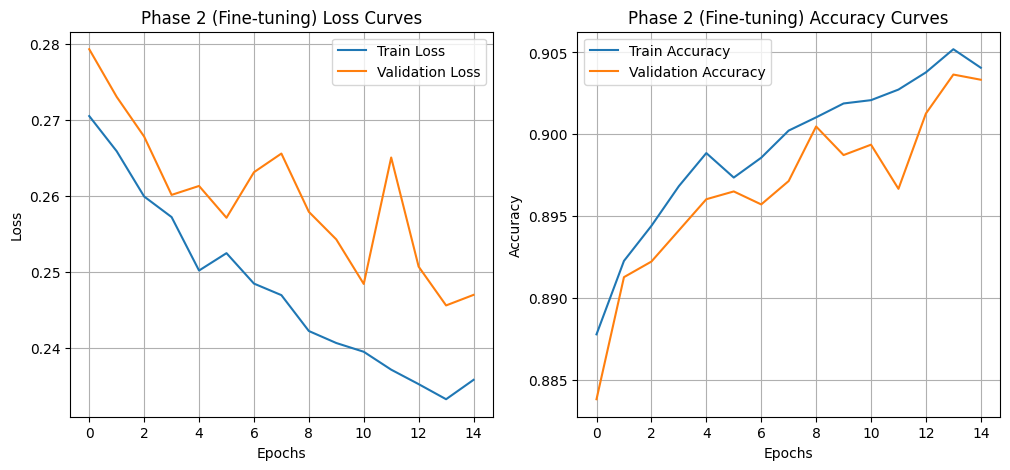

In [ ]:
# --- 5. PLOT FINE-TUNING CURVES ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_ft['train_loss'], label='Train Loss')
plt.plot(history_ft['val_loss'], label='Validation Loss')
plt.title('Phase 2 (Fine-tuning) Loss Curves'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(history_ft['train_acc'], label='Train Accuracy')
plt.plot(history_ft['val_acc'], label='Validation Accuracy')
plt.title('Phase 2 (Fine-tuning) Accuracy Curves'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
plt.show()

STEP 1: Installing utilities and importing libraries...

STEP 2: Configuring for evaluation...
Mounted at /content/drive
Local test set found.

STEP 3: Loading the Fine-Tuned model and test data...
✅ Model and test data loaded successfully.

STEP 4: Running evaluation...

--- Evaluation Results (After Phase 2 - Fine-Tuning) ---

Classification Report:
                precision    recall  f1-score   support

 bad_skeletons     0.9185    0.8906    0.9044      3026
good_skeletons     0.8938    0.9210    0.9072      3026

      accuracy                         0.9058      6052
     macro avg     0.9062    0.9058    0.9058      6052
  weighted avg     0.9062    0.9058    0.9058      6052


Overall Accuracy: 90.58%
Precision: 0.8938, Recall: 0.9210, AUC: 0.9634



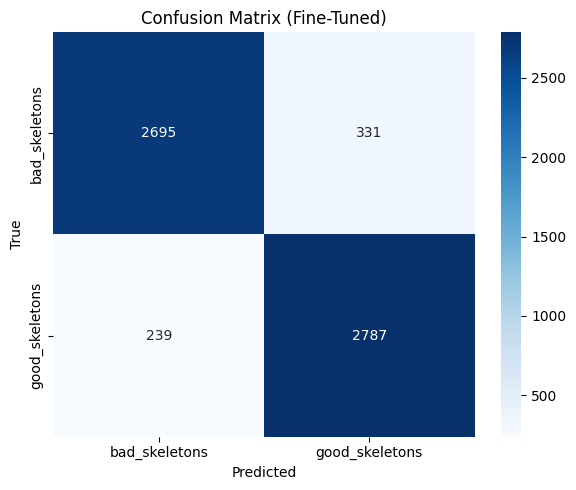

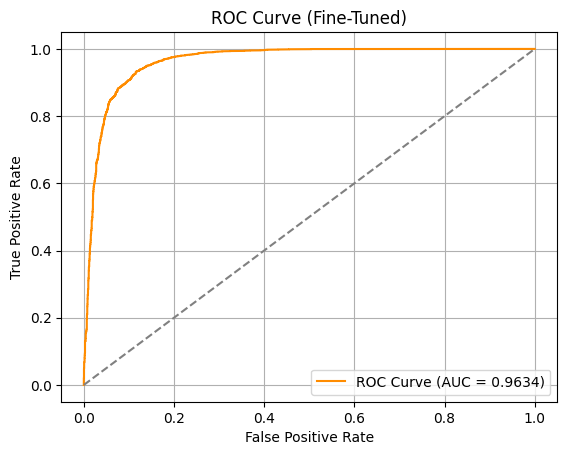

In [ ]:
# =================================================================
# EVALUATION SCRIPT FOR THE PHASE 2 (FINE-TUNED) MODEL
# =================================================================

# --- 1. SETUP LIBRARIES ---
print("STEP 1: Installing utilities and importing libraries...")
!pip install -q timm
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# --- 2. CONFIGURATION ---
print("\nSTEP 2: Configuring for evaluation...")
drive.mount('/content/drive', force_remount=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- IMPORTANT: Path to the FINAL model saved from PHASE 2 ---
best_model_path = "/content/drive/My Drive/ProMotionFx_CNN_Skeleton/vit_finetuned_skeleton.pth"

# Path to your test data
test_path = "/content/local_quality_dataset/quality_sorted_dataset/test"

# Make sure the local data exists if this is a new session
if not os.path.exists(test_path):
    print("Local dataset not found. Please run the data setup part of the training script first.")
else:
    print("Local test set found.")

# --- 3. LOAD CHECKPOINT AND PREPARE MODEL ---
print("\nSTEP 3: Loading the Fine-Tuned model and test data...")
if not os.path.exists(best_model_path):
    print(f"❌ CRITICAL ERROR: Model checkpoint not found at '{best_model_path}'")
else:
    checkpoint = torch.load(best_model_path)

    img_size = (224, 224)
    batch_size = 32

    # Dataloader for test set
    test_transforms = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    class_names = test_dataset.classes

    # Define the ViT model architecture
    eval_model = timm.create_model('vit_base_patch16_224', pretrained=False)
    num_ftrs = eval_model.head.in_features
    eval_model.head = nn.Sequential(
        nn.Linear(num_ftrs, 128), nn.ReLU(), nn.Dropout(0.3), nn.Linear(128, 1), nn.Sigmoid()
    )

    # Load the weights from the Phase 2 checkpoint
    eval_model.load_state_dict(checkpoint['model_state'])
    eval_model.to(device)
    eval_model.eval()
    print("✅ Model and test data loaded successfully.")

    # --- 4. RUN EVALUATION ---
    print("\nSTEP 4: Running evaluation...")
    all_labels, all_preds, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = eval_model(images).squeeze()
            probs = outputs.cpu().numpy()
            preds = (outputs >= 0.5).float().cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)
            all_probs.extend(probs)

    # --- 5. DISPLAY METRICS AND PLOTS ---
    print("\n--- Evaluation Results (After Phase 2 - Fine-Tuning) ---")
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    auc_score = roc_auc_score(all_labels, all_probs)
    precision = cm[1,1] / (cm[0,1] + cm[1,1]) if (cm[0,1] + cm[1,1]) > 0 else 0
    recall = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0

    print(f"\nOverall Accuracy: {acc*100:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc_score:.4f}\n")

    plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (Fine-Tuned)'); plt.tight_layout(); plt.show()

    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(); plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})', color='darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve (Fine-Tuned)'); plt.legend(); plt.grid(True); plt.show()